# Import required libraries

In [45]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.cm as cm
import scipy.stats
from matplotlib import pyplot as plt 
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, Input
from keras.layers import BatchNormalization
from tensorflow.keras import regularizers


# prevent tensorflow from allocating the entire GPU memory at once
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.compat.v1.Session(config=config)

In [46]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [47]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer
#from tensorflow.keras.engine.topology import Layer

def init_identities(shape, dtype=None):
	out = np.zeros(shape)
	for r in range(shape[2]):
		for i in range(shape[0]):
			out[i,i,r] = 1.0
	return out
	
class CrowdsClassification(Layer):

	def __init__(self, output_dim, num_annotators, conn_type="MW", **kwargs):
		self.output_dim = output_dim
		self.num_annotators = num_annotators
		self.conn_type = conn_type
		super(CrowdsClassification, self).__init__(**kwargs)

	def build(self, input_shape):
		if self.conn_type == "MW":
			# matrix of weights per annotator
			self.kernel = self.add_weight("CrowdLayer", (self.output_dim, self.output_dim, self.num_annotators),
											initializer=init_identities, 
											trainable=True)
		elif self.conn_type == "VW":
			# vector of weights (one scale per class) per annotator
			self.kernel = self.add_weight("CrowdLayer", (self.output_dim, self.num_annotators),
											initializer=keras.initializers.Ones(), 
											trainable=True)
		elif self.conn_type == "VB":
			# two vectors of weights (one scale and one bias per class) per annotator
			self.kernel = []
			self.kernel.append(self.add_weight("CrowdLayer", (self.output_dim, self.num_annotators),
											initializer=keras.initializers.Zeros(),
											trainable=True))
		elif self.conn_type == "VW+B":
			# two vectors of weights (one scale and one bias per class) per annotator
			self.kernel = []
			self.kernel.append(self.add_weight("CrowdLayer", (self.output_dim, self.num_annotators),
											initializer=keras.initializers.Ones(),
											trainable=True))
			self.kernel.append(self.add_weight("CrowdLayer", (self.output_dim, self.num_annotators),
											initializer=keras.initializers.Zeros(),
											trainable=True))
		elif self.conn_type == "SW":
			# single weight value per annotator
			self.kernel = self.add_weight("CrowdLayer", (self.num_annotators,1),
											initializer=keras.initializers.Ones(),
											trainable=True)
		else:
			raise Exception("Unknown connection type for CrowdsClassification layer!")

		super(CrowdsClassification, self).build(input_shape)  # Be sure to call this somewhere!

	def call(self, x):
		if self.conn_type == "MW":
			res = K.dot(x, self.kernel)
		elif self.conn_type == "VW" or self.conn_type == "VB" or self.conn_type == "VW+B" or self.conn_type == "SW":
			out = []
			for r in range(self.num_annotators):
				if self.conn_type == "VW":
					out.append(x * self.kernel[:,r])
				elif self.conn_type == "VB":
					out.append(x + self.kernel[0][:,r])
				elif self.conn_type == "VW+B":
					out.append(x * self.kernel[0][:,r] + self.kernel[1][:,r])
				elif self.conn_type == "SW":
					out.append(x * self.kernel[r,0])
			res = tf.stack(out)
			if len(res.shape) == 3:
				res = tf.transpose(res, [1, 2, 0])
			elif len(res.shape) == 4:
				res = tf.transpose(res, [1, 2, 3, 0])
			else:
				raise Exception("Wrong number of dimensions for output")
		else:
			raise Exception("Unknown connection type for CrowdsClassification layer!") 
		
		return res

	def compute_output_shape(self, input_shape):
		return (input_shape[0], self.output_dim, self.num_annotators)


class CrowdsRegression(Layer):

	def __init__(self, num_annotators, conn_type="B", **kwargs):
		self.num_annotators = num_annotators
		self.conn_type = conn_type
		super(CrowdsRegression, self).__init__(**kwargs)

	def build(self, input_shape):
		self.kernel = []
		if self.conn_type == "S":
			# scale-only parameter
			self.kernel.append(self.add_weight("CrowdLayer", (1, self.num_annotators),
								  initializer=keras.initializers.Ones(),
								  trainable=True))
		elif self.conn_type == "B":
			# bias-only parameter
			self.kernel.append(self.add_weight("CrowdLayer", (1, self.num_annotators),
								  initializer=keras.initializers.Zeros(),
								  trainable=True))
		elif self.conn_type == "S+B" or self.conn_type == "B+S":
			# scale and bias parameters
			self.kernel.append(self.add_weight("CrowdLayer", (1, self.num_annotators),
									  initializer=keras.initializers.Ones(),
									  trainable=True))
			self.kernel.append(self.add_weight("CrowdLayer", (1, self.num_annotators),
									  initializer=keras.initializers.Zeros(),
									  trainable=True))
		else:
			raise Exception("Unknown connection type for CrowdsRegression layer!") 

		super(CrowdsRegression, self).build(input_shape)  # Be sure to call this somewhere!

	def call(self, x):
		if self.conn_type == "S":
			#res = K.dot(x, self.kernel[0])
			res = x * self.kernel[0]
		elif self.conn_type == "B":
			res = x + self.kernel[0]
		elif self.conn_type == "S+B":
			#res = K.dot(x, self.kernel[0]) + self.kernel[1]
			res = x * self.kernel[0] + self.kernel[1]
		elif self.conn_type == "B+S":
			res = (x + self.kernel[1]) * self.kernel[0]
		else:
			raise Exception("Unknown connection type for CrowdsClassification layer!") 

		return res

	def compute_output_shape(self, input_shape):
		return (input_shape[0], self.num_annotators)


class MaskedMultiCrossEntropy(object):

	def loss(self, y_true, y_pred):
		vec = tf.nn.softmax_cross_entropy_with_logits(logits=y_pred, labels=y_true, axis=1)
		mask = tf.equal(y_true[:,0,:], -1)
		zer = tf.zeros_like(vec)
		loss = tf.where(mask, x=zer, y=vec)
		return loss


class MaskedMultiMSE(object):
		
	def loss(self, y_true, y_pred):
		vec = K.square(y_pred - y_true)
		mask = tf.equal(y_true[:,:], 999999999)
		zer = tf.zeros_like(vec)
		loss = tf.where(mask, x=zer, y=vec)
		return loss


class MaskedMultiSequenceCrossEntropy(object):

	def __init__(self, num_classes):
		self.num_classes = num_classes

	def loss(self, y_true, y_pred):
		mask_missings = tf.equal(y_true, -1)
		mask_padding = tf.equal(y_true, 0)

		# convert targets to one-hot enconding and transpose
		y_true = tf.transpose(tf.one_hot(tf.cast(y_true, tf.int32), self.num_classes, axis=-1), [0,1,3,2])

		# masked cross-entropy
		vec = tf.nn.softmax_cross_entropy_with_logits(logits=y_pred, labels=y_true, axis=2)
		zer = tf.zeros_like(vec)
		vec = tf.where(mask_missings, x=zer, y=vec)
		vec = tf.where(mask_padding, x=zer, y=vec)
		loss = tf.reduce_mean(vec, axis=-1)
		return loss


class CrowdsAggregationCategoricalCrossEntropy(object):

	def __init__(self, num_classes, num_annotators, pi_prior=0.01):
		self.num_classes = num_classes
		self.num_annotators = num_annotators
		self.pi_prior = pi_prior
		
		# initialize pi_est (annotators' estimated confusion matrices) wit identities
		self.pi_est = np.zeros((self.num_classes,self.num_classes,self.num_annotators), dtype=np.float32)
		for r in range(self.num_annotators):
			self.pi_est[:,:,r] = np.eye(self.num_classes) + self.pi_prior
			self.pi_est[:,:,r] /= np.sum(self.pi_est[:,:,r], axis=1)
			
		self.init_suff_stats()
			
	def init_suff_stats(self):
		# initialize suff stats for M-step
		self.suff_stats = self.pi_prior * tf.ones((self.num_annotators,self.num_classes,self.num_classes))
		
	def loss_fc(self, y_true, y_pred):
		y_true = tf.cast(y_true, tf.int32)

		#y_pred += 0.01
		#y_pred /= tf.reduce_sum(y_pred, reduction_indices=len(y_pred.get_shape()) - 1, keep_dims=True)

		#y_pred = tf.where(tf.less(y_pred, 0.001), 
		#                        #0.01 * tf.ones_like(y_pred), 
		#                        0.001 + y_pred, 
		#                        y_pred)
		#y_pred += 0.01 # y_pred cannot be zero!
		eps = 1e-3
		#y_pred = tf.clip_by_value(y_pred, eps, 1.0 - eps)
		y_pred = tf.clip_by_value(y_pred, eps, 9999999999)


		# E-step
		adjustment_factor = tf.ones_like(y_pred)
		for r in range(self.num_annotators):
			adj = tf.where(tf.equal(y_true[:,r], -1), 
								tf.ones_like(y_pred), 
								tf.gather(tf.transpose(self.pi_est[:,:,r]), y_true[:,r]))
			adjustment_factor = tf.multiply(adjustment_factor, adj)
			
		res = tf.multiply(adjustment_factor, y_pred)
		y_agg = res / tf.expand_dims(tf.reduce_sum(res, axis=1), 1)

		loss = -tf.reduce_sum(y_agg * tf.log(y_pred), reduction_indices=[1])
		
		# update suff stats
		upd_suff_stats = []
		for r in range(self.num_annotators):
			#print r
			suff_stats = []
			normalizer = tf.zeros_like(y_pred)
			for c in range(self.num_classes):
				suff_stats.append(tf.reduce_sum(tf.where(tf.equal(y_true[:,r], c), 
									y_agg,
									tf.zeros_like(y_pred)), axis=0))
			upd_suff_stats.append(suff_stats)
		upd_suff_stats = tf.stack(upd_suff_stats)
		self.suff_stats += upd_suff_stats

		return loss
	
	def m_step(self):
		#print "M-step"
		self.pi_est = tf.transpose(self.suff_stats / tf.expand_dims(tf.reduce_sum(self.suff_stats, axis=2), 2), [1, 2, 0])
		
		return self.pi_est


class CrowdsAggregationBinaryCrossEntropy(object):

	def __init__(self, num_annotators, pi_prior=0.01, alpha=None, beta=None, update_freq=1):
		self.num_annotators = num_annotators
		self.pi_prior = pi_prior
		self.alpha = alpha
		self.beta = beta
		self.update_freq = update_freq
		
		# initialize alpha and beta (annotators' estimated sensitivity and specificity)
		if self.alpha == None:
			print("initializing alpha with unit...")
			self.alpha = 0.99*np.ones((self.num_annotators,1), dtype=np.float32)
		if self.beta == None:
			self.beta = 0.99*np.ones((self.num_annotators,1), dtype=np.float32)
		self.count = tf.ones(1)
			
		self.suff_stats_alpha = [self.pi_prior for r in range(self.num_annotators)]
		self.suff_stats_beta = [self.pi_prior for r in range(self.num_annotators)]
		self.suff_stats_alpha_norm = [self.pi_prior for r in range(self.num_annotators)]
		self.suff_stats_beta_norm = [self.pi_prior for r in range(self.num_annotators)]
			
	def init_suff_stats(self):
		# initialize suff stats for M-step
		pass

	def loss_fc(self, y_true, y_pred):
		#y_true = tf.cast(y_true, tf.int32)

		#y_pred += 0.01
		#y_pred /= tf.reduce_sum(y_pred, reduction_indices=len(y_pred.get_shape()) - 1, keep_dims=True)

		#y_pred = tf.where(tf.less(y_pred, 0.001), 
		#                        #0.01 * tf.ones_like(y_pred), 
		#                        0.001 + y_pred, 
		#                        y_pred)
		#y_pred += 0.01 # y_pred cannot be zero!
		eps = 1e-3
		y_pred = tf.clip_by_value(y_pred, eps, 1.0 - eps)
		#y_pred = tf.clip_by_value(y_pred, eps, 9999999999)

		p = y_pred[:,1]
		self.count += 1
		self.count = tf.Print(self.count, [self.count])
		#self.count += 1

		if False:
			print("M-step...")
			self.alpha = []
			self.beta = []
			for r in range(self.num_annotators):
				self.alpha.append(self.suff_stats_alpha[r] / self.suff_stats_alpha_norm[r])
				self.beta.append(self.suff_stats_beta[r] / self.suff_stats_beta_norm[r])
			self.count = 0
			self.suff_stats_alpha = [self.pi_prior for r in range(self.num_annotators)]
			self.suff_stats_beta = [self.pi_prior for r in range(self.num_annotators)]
			self.suff_stats_alpha_norm = [self.pi_prior for r in range(self.num_annotators)]
			self.suff_stats_beta_norm = [self.pi_prior for r in range(self.num_annotators)]
			self.alpha = tf.Print(self.alpha, [self.alpha])

		
		# E-step
		a = tf.ones_like(p)
		b = tf.ones_like(p)
		for r in range(self.num_annotators):
			a = a * tf.where(tf.equal(y_true[:,r], 1), self.alpha[r]*tf.ones_like(p), tf.ones_like(p))
			b = b * tf.where(tf.equal(y_true[:,r], 1), (1.0-self.beta[r])*tf.ones_like(p), tf.ones_like(p))
			a = a * tf.where(tf.equal(y_true[:,r], 0), (1.0-self.alpha[r])*tf.ones_like(p), tf.ones_like(p))
			b = b * tf.where(tf.equal(y_true[:,r], 0), self.beta[r]*tf.ones_like(p), tf.ones_like(p))
		
		mu = (a*p) / (a*p + b*(1.0-p))
		#mu = tf.Print(mu, [mu])
		loss = - (mu * tf.log(y_pred[:,1]) + (1.0-mu) * tf.log(y_pred[:,0]))

		# update suff stats
		for r in range(self.num_annotators):
			self.suff_stats_alpha[r] += tf.reduce_sum(tf.where(tf.equal(y_true[:,r], 1), mu, tf.zeros_like(p)))
			self.suff_stats_beta[r] += tf.reduce_sum(tf.where(tf.equal(y_true[:,r], 0), (1.0-mu), tf.zeros_like(p)))
			self.suff_stats_alpha_norm[r] += tf.reduce_sum(tf.where(tf.equal(y_true[:,r], -1), tf.zeros_like(p), mu))
			self.suff_stats_beta_norm[r] += tf.reduce_sum(tf.where(tf.equal(y_true[:,r], -1), tf.zeros_like(p), (1.0-mu)))
		
		return loss
	
	def m_step(self):
		print((dir(self)))
		print(("debug:", self.count.eval()))
		#print "M-step"
		#self.count += 1
		#print "increment", self.count
		#if self.count >= self.update_freq:
			
			
		
		return (self.alpha, self.beta)


class CrowdsAggregationCallback(keras.callbacks.Callback):

	def __init__(self, loss):
		self.loss = loss
		
	def on_epoch_begin(self, epoch, logs=None):
		self.loss.init_suff_stats()
		
	def on_epoch_end(self, epoch, logs=None):
		# run M-step
		self.model.pi = self.loss.m_step()



In [48]:
import os
import sys
# os.chdir('/content/drive/MyDrive/CrowdLayer-R')
# cwd = os.getcwd()
# sys.path.append("/content/drive/MyDrive/CrowdLayer-R/crowd_layer")
# # packages for learning from crowds
# from crowd_layer.crowd_layers import CrowdsClassification, MaskedMultiCrossEntropy
# from crowd_layer.crowd_aggregators import CrowdsCategoricalAggregator

In [49]:
train_data = tf.data.experimental.load('/content/drive/Shareddrives/Multiple Anotators/CrowdLayer/Data/cats_dogs_Tr')
Test_data = tf.data.experimental.load('/content/drive/Shareddrives/Multiple Anotators/CrowdLayer/Data/cats_dogs_Te')

In [50]:
image_count_train = tf.data.experimental.cardinality(train_data).numpy()
image_count_train

18610

In [51]:
image_count_test = tf.data.experimental.cardinality(Test_data).numpy()
image_count_test

4652

In [52]:
subset = 18610
train_data = train_data.take(18610)
image_count1 = tf.data.experimental.cardinality(train_data).numpy()
image_count1

18610

In [53]:
image_count = 3000
 
val_size = int(image_count1 * 0.25)
train_ds = train_data.skip(val_size)
val_ds  = train_data.take(val_size)

In [54]:
image_count_val = tf.data.experimental.cardinality(val_ds).numpy()
image_count_val

4652

In [55]:
image_count_Tr = tf.data.experimental.cardinality(train_ds).numpy()
image_count_Tr

13958

In [56]:
batch_size = 150
train_batches= train_ds.shuffle(1024).batch(batch_size)
val_batches = val_ds.shuffle(1024).batch(50)
test_batches = Test_data.shuffle(1024).batch(50)

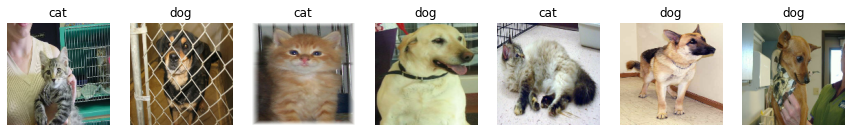

In [57]:
classNames = ['cat', 'dog']


i = 0

fig, ax = plt.subplots(1, 7, figsize=(15,15))
 
for image,label in train_ds.take(7):
 #  print(image.shape)
 #   predictedLabel = int(predictions[i] >= 0.5)
   # print(label)
   ax[i].axis('off')
   ax[i].set_title(classNames[label.numpy()])
   ax[i].imshow(image)
    
   i += 1
 
# plt.show()

# Configuration parameters

In [58]:
# DATA_PATH = "/home/fmpr/datasets/deep-crowds-datasets/dogs_vs_cats_sim/prepared/"
N_CLASSES = 2
BATCH_SIZE = 128


# Define the base deep learning model

Here we shall use features representation produced by the VGG16 network as the input. Our base model is then simply composed by one densely-connected layer with 128 hidden units and an output dense layer. We use 50% dropout between the two dense layers.

In [59]:
def build_base_model():
    
    base_model = Sequential()
    base_model.add(BatchNormalization())
    base_model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
    base_model.add(Activation('relu'))
    base_model.add(BatchNormalization())
    base_model.add(MaxPooling2D(pool_size=(2, 2)))
   # base_model.add(Dropout(0.2))
   
    base_model.add(BatchNormalization())
    base_model.add(Conv2D(32, (3, 3)))
    base_model.add(Activation('relu'))
    base_model.add(BatchNormalization())
    base_model.add(MaxPooling2D(pool_size=(2, 2)))
   # base_model.add(Dropout(0.2))
    

    base_model.add(BatchNormalization())
    base_model.add(Conv2D(64, (3, 3)))
    base_model.add(Activation('relu'))
    base_model.add(BatchNormalization())
    base_model.add(MaxPooling2D(pool_size=(2, 2)))
   # base_model.add(Dropout(0.2))

    base_model.add(BatchNormalization())
    base_model.add(Conv2D(64, (3, 3)))
    base_model.add(Activation('relu'))
    base_model.add(BatchNormalization())
    base_model.add(MaxPooling2D(pool_size=(2, 2)))
   # base_model.add(Dropout(0.2))


    base_model.add(Flatten()) 
    base_model.add(BatchNormalization())
    base_model.add(Dense(128))
    base_model.add(Activation('relu'))
    base_model.add(BatchNormalization())
    base_model.add(Dropout(0.2))
    base_model.add(Dense(N_CLASSES))
    base_model.add(Activation('softmax'))

    base_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, clipnorm = 1.0), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return base_model

In [60]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=10, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model1.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

# Train the model on the true labels (ground truth) and evaluate on testset

iteration: 0
Epoch 1/50
93/94 [============================>.] - ETA: 0s - loss: 0.6909 - accuracy: 0.6862
Epoch 1: val_loss improved from inf to 1.32147, saving model to model1.h5
94/94 [==============================] - 39s 355ms/step - loss: 0.6907 - accuracy: 0.6863 - val_loss: 1.3215 - val_accuracy: 0.5118 - lr: 0.0010
Epoch 2/50
93/94 [============================>.] - ETA: 0s - loss: 0.4448 - accuracy: 0.7956
Epoch 2: val_loss improved from 1.32147 to 0.96347, saving model to model1.h5
94/94 [==============================] - 37s 355ms/step - loss: 0.4451 - accuracy: 0.7955 - val_loss: 0.9635 - val_accuracy: 0.5131 - lr: 0.0010
Epoch 3/50
93/94 [============================>.] - ETA: 0s - loss: 0.3518 - accuracy: 0.8446
Epoch 3: val_loss improved from 0.96347 to 0.52476, saving model to model1.h5
94/94 [==============================] - 38s 366ms/step - loss: 0.3518 - accuracy: 0.8446 - val_loss: 0.5248 - val_accuracy: 0.7373 - lr: 0.0010
Epoch 4/50
93/94 [======================

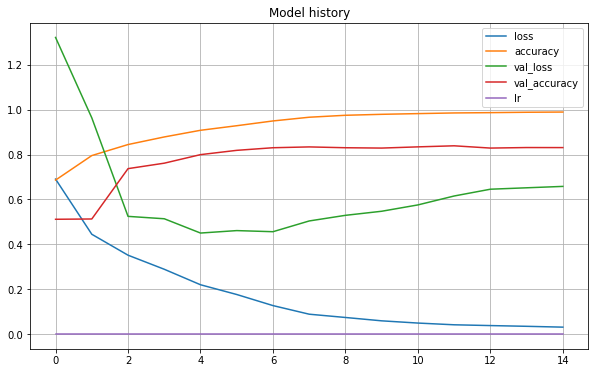

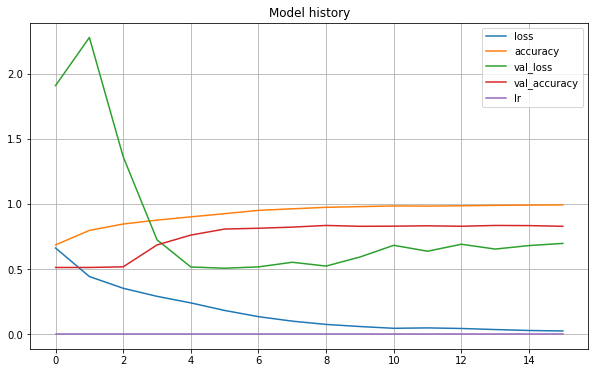

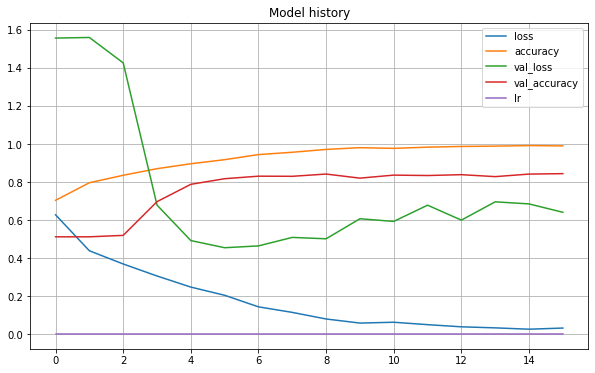

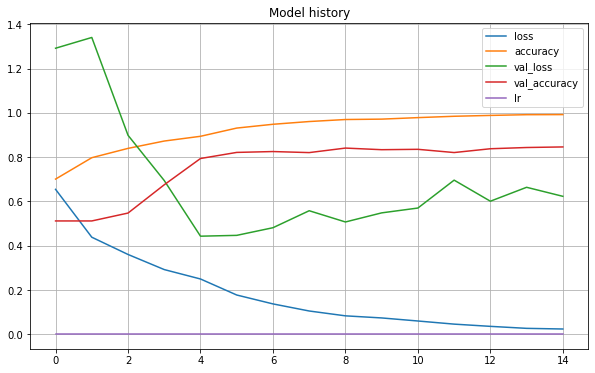

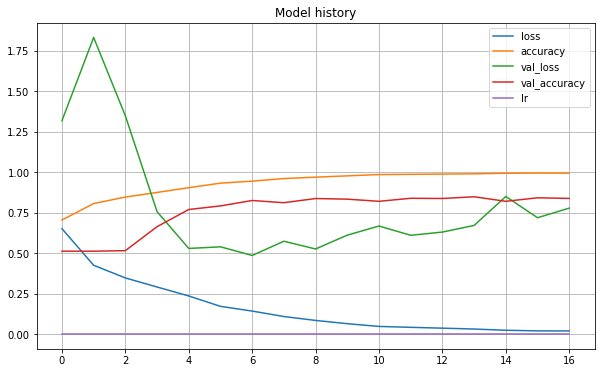

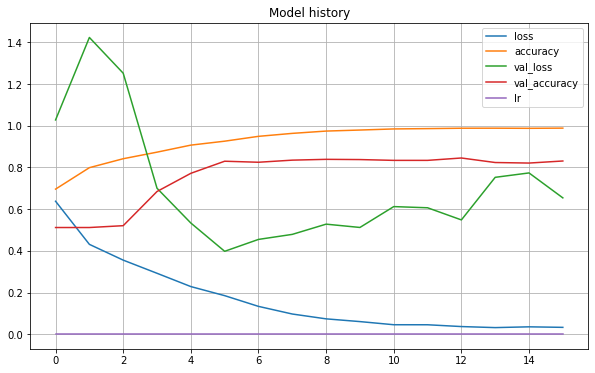

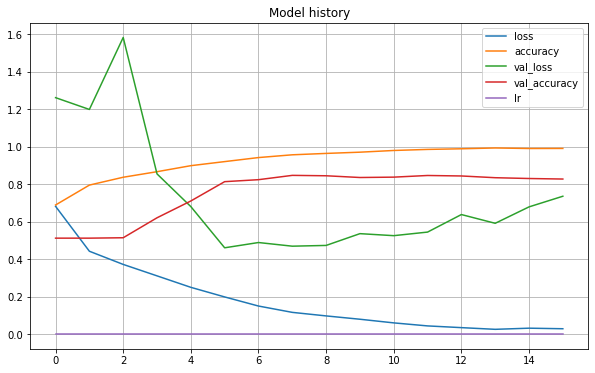

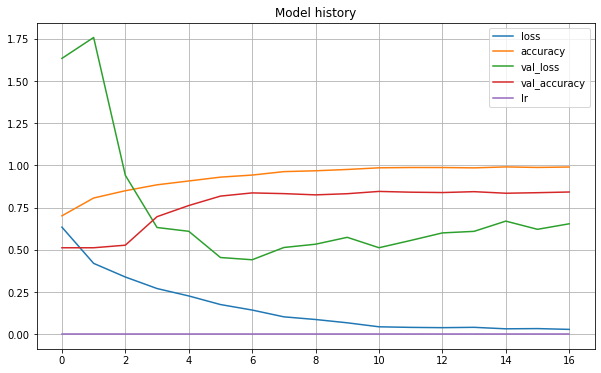

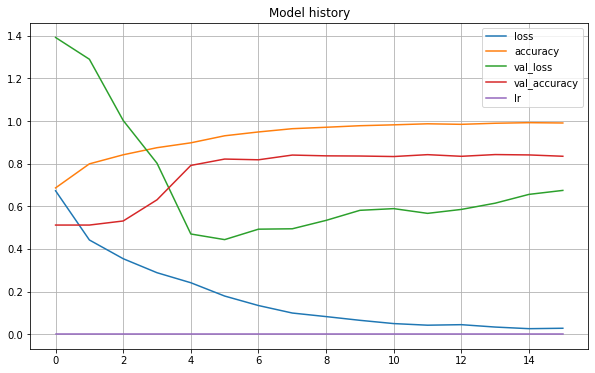

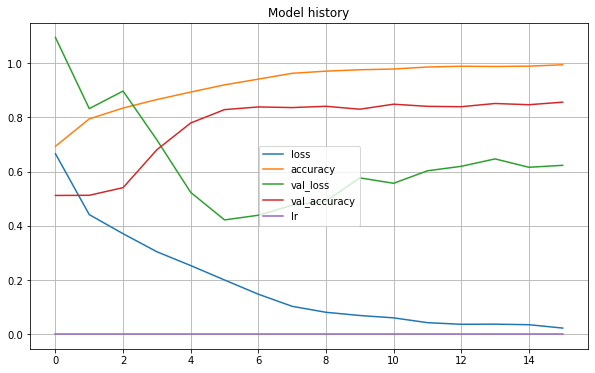

In [61]:

from sklearn.metrics import classification_report
l1 =   0.001
NUM_RUNS = 10
N_EPOCHS = 50
val_acc_goldst= np.zeros(NUM_RUNS)
AUC = np.zeros(NUM_RUNS)
for k in range(NUM_RUNS): #10
    print("iteration: " + str(k))
    model = build_base_model()  
    trainHistory = model.fit(train_batches, validation_data= val_batches, epochs=N_EPOCHS,  callbacks=callbacks)
    # Create the history figure
    plt.figure(figsize=(10,6))
    for i in  trainHistory.history:
        plt.plot( trainHistory.history[i],label=i)
    plt.title('Model history')
    plt.legend()
    plt.grid()
  
    #Accuracy
    (loss, accuracy) = model.evaluate(test_batches)
    val_acc_goldst[k] = accuracy
 
     
    #AUC

    val_AUC_metric = tf.keras.metrics.AUC(num_thresholds=3, from_logits = True)
    for x_batch_val, y_batch_val in test_batches:
        val_logits = model(x_batch_val.numpy(), training=False)
      # tf.print(y_batch_val)
        val_AUC_metric.update_state(y_batch_val, val_logits.numpy().argmax(axis=1).astype('float'))

    val_AUC = val_AUC_metric.result()
    val_AUC_metric.reset_states()
    val_AUC = val_AUC.numpy()
    print("Validation AUC: %.4f" % (float(val_AUC),))
    AUC[k] = val_AUC

In [66]:
val_acc_goldst

array([0.83877903, 0.83899397, 0.83791918, 0.8422184 , 0.84823734,
       0.83748925, 0.83104044, 0.85081685, 0.83340496, 0.8422184 ])

In [67]:
AUC

array([0.83792496, 0.83945405, 0.83792377, 0.84181643, 0.84731036,
       0.83756179, 0.83266693, 0.85075855, 0.83385438, 0.84201205])

In [68]:
print('Average Accuracy: ', np.round(val_acc_goldst.mean(),4)*100) 
print('Average std: ',np.round(np.std(val_acc_goldst),4)*100)


Average Accuracy:  84.00999999999999
Average std:  0.58


In [69]:
print('Average Accuracy: ', np.round( AUC.mean(),4)*100) 
print('Average std: ',np.round(np.std( AUC),4)*100)


Average Accuracy:  84.00999999999999
Average std:  0.53
